In [1]:
import pandas as pd
import matplotlib.pyplot as plt

hc_label = "HC (kVA)"
ctpv_label = "CTPV (Milhões de USD)"


In [2]:
from dataclasses import dataclass
import networkx as nx

def parser_pareto(path: str) -> pd.DataFrame:
    lines = []
    with open(path, "r") as file:
        lines = file.readlines()

    out = {hc_label: [], ctpv_label: [] }
    for line in lines:
        if "Pareto | HC" in line:
            tokens = line.split()
            out["HC (kVA)"].append(float(tokens[-1])*1e3)
        elif "Pareto | CTPV" in line:
            tokens = line.split()
            out["CTPV (Milhões de USD)"].append(float(tokens[-1])/1e6)
    return pd.DataFrame(data=out)
        


@dataclass
class Line:
    category: str
    bus1: int
    bus2: int
    alternative: int
    time: int
    def __hash__(self) -> int:
        return hash(f"LINE{self.category},{self.bus1},{self.bus2}, {self.alternative}, {self.time}")
    

@dataclass
class DG:
    category: str
    bus: int
    alternative: int
    time: int
    def __hash__(self) -> int:
        return hash(f"DG{self.category},{self.bus}, {self.alternative}, {self.time}")

@dataclass
class Substation:
    bus: int
    time: int
    def __hash__(self) -> int:
        return hash(f"SUB{self.bus},{self.time}")
    
@dataclass
class Transformer:
    category: str
    bus: int
    alternative: int
    time: int
    def __hash__(self) -> int:
        return hash(f"TR{self.category},{self.bus}, {self.alternative}, {self.time}")

@dataclass
class System:
    nnodes: int
    lines: set[Line]
    dgs: set[DG]
    substations: set[Transformer]
    nodes_substation: set[int]

@dataclass
class Investiment:
    lines: set[Line]
    dgs: set[DG]
    substations: set[Substation]
    transformers: set[Transformer]


def parser_system(path: str, nnodes: int) -> System:
    lines = []
    
    with open(path, "r") as file:
        lines = file.readlines()

    sys = System(nnodes, set(), set(), set(), set())

    keep_print = False
    variable = ""
    for line in lines:
        if len(line) < 2:
            continue
        if line[-2] == ":":
            if "y" in line:
                keep_print = True
                variable = line[0:len(line)-2]
                continue
            else:
                keep_print = False
                continue

        if keep_print:
            data = line.split(",")
            value = data[-1]
            data[-1] = value.split(":")[0]       

            value = value.split(":")[1]
            value = bool(int(value[0:len(value)-2]))

            if value:            
                if "yˡ" in variable:
                    obj = Line(data[0], int(data[1]), int(data[2]), int(data[3]), int(data[4]))
                    sys.lines.add(obj)
                elif "yᵖ" in variable:
                    obj = DG(data[0], int(data[1]), int(data[2]), int(data[3]))
                    sys.dgs.add(obj)
                elif "yᵗʳ" in variable:
                    sys.nodes_substation.add(int(data[1]))
                    obj = Transformer(data[0], int(data[1]), int(data[2]), int(data[3]))
                    sys.substations.add(obj)
                else:
                    raise RuntimeError(f"Unreacable: {variable}: {line}")
            else:
                if "yᵗʳ" in variable:
                    sys.nodes_substation.add(int(data[1]))
    
    return sys



def parser_investiment(path: str, substation_nodes: list[int], times: list[int]) -> Investiment:
    lines = []
    
    with open(path, "r") as file:
        lines = file.readlines()

    sys = Investiment(set(), set(), set(), set())

    keep_print = False
    variable = ""
    for line in lines:
        if len(line) < 2:
            continue
        if line[-2] == ":":
            if "x" in line:
                keep_print = True
                variable = line[0:len(line)-2]
                continue
            else:
                keep_print = False
                continue

        if keep_print:
            data = line.split(",")
            value = data[-1]
            data[-1] = value.split(":")[0]       

            value = value.split(":")[1]
            value = bool(int(value[0:len(value)-2]))

            if value:            
                if "xˡ" in variable:
                    obj = Line(data[0], int(data[1]), int(data[2]), int(data[3]), int(data[4]))
                    sys.lines.add(obj)
                elif "xᵖ" in variable:
                    obj = DG(data[0], int(data[1]), int(data[2]), int(data[3]))
                    sys.dgs.add(obj)
                elif "xᴺᵀ" in variable:
                    obj = Transformer("NT", substation_nodes[int(data[0]) -1], int(data[1]), times[int(data[2])-1])
                    sys.transformers.add(obj)
                elif "xˢˢ" in variable:
                    obj = Substation(substation_nodes[int(data[0]) -1], times[int(data[1])-1])
                    sys.substations.add(obj)
                else:
                    raise RuntimeError(f"Unreacable: {variable}: {line}")
    
    return sys


def draw(sys: System, time, pos, pos_sh, ax, main_font_size=8, sec_font_size=6, node_size=300):
    G = nx.Graph()
    G.add_nodes_from(range(1, sys.nnodes + 1))
    edges = [(line.bus1, line.bus2) for line in sys.lines if line.time == time]
    labels = {(line.bus1, line.bus2): f"{line.category}{line.alternative}" for line in sys.lines if line.time == time}
    G.add_edges_from(edges)

    nx.draw_networkx_nodes(G, pos, nodelist=sys.nodes_substation, node_shape='s', node_color="white", linewidths=0.5, node_size=node_size, edgecolors="black", ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[n for n in range(1, sys.nnodes + 1) if n not in sys.nodes_substation], node_size=node_size, node_shape='o', node_color="white",linewidths=0.5, edgecolors="black", ax=ax)
   

    nx.draw_networkx_edges(G, pos, ax=ax)

    _ = nx.draw_networkx_edge_labels(G, pos, labels, font_size=sec_font_size, verticalalignment="center",
                                     rotate=False, label_pos=0.5, bbox=dict(alpha=1, color="white", edgecolor='none', pad=0),
                                     clip_on=False, ax=ax)

    nx.draw_networkx_labels(G, pos, font_size=main_font_size, verticalalignment="center", ax=ax, bbox=dict(alpha=0, color="white", edgecolor='none', pad=0))
    
    G_gen = nx.Graph()
    G_gen.add_nodes_from([dg.bus for dg in sys.dgs if dg.time == time])
    labels_dg = {dg.bus:f"{dg.category}{dg.alternative}" for dg in sys.dgs if dg.time == time}

    labels_tr = {sub.bus:f"{sub.category}{sub.alternative}" for sub in sys.substations if sub.time == time}
    nx.draw_networkx_labels(G_gen, pos_sh, labels=labels_dg, font_size=sec_font_size, verticalalignment="center", ax=ax, bbox=dict(alpha=1, color="white", edgecolor='none', pad=0))
    nx.draw_networkx_labels(G_gen, pos_sh, labels=labels_tr, font_size=sec_font_size, verticalalignment="center", ax=ax, bbox=dict(alpha=1, color="white", edgecolor='none', pad=0))
    ax.margins(0.0, 0.0)


## 24 bus

In [3]:
df_both = parser_pareto("../../info_mult_24_both.log")
df_ev = parser_pareto("../../info_mult_24_ev.log")
df_gen = parser_pareto("../../info_mult_24_gen.log")

### CTPV

#### Raw

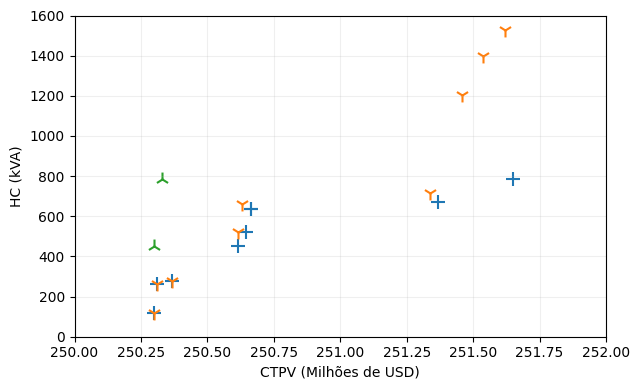

In [4]:
fig, ax = plt.subplots(figsize=(6.5, 4), layout="tight", dpi=100)
ax.set_xlabel(ctpv_label)
ax.set_ylabel(hc_label)
ax.set_xlim((250, 252))
ax.set_ylim((0, 1600))
ax.grid(alpha=0.2)
ax.scatter(df_both[ctpv_label], df_both[hc_label], label="Both", marker="+", s=100)
ax.scatter(
    df_ev[ctpv_label], df_ev[hc_label], label="Only for EV/Loads", marker="1", s=100
)
ax.scatter(df_gen[ctpv_label], df_gen[hc_label], label="Only for DG", marker="2", s=100)
ax.scatter([-999], [-999], label="Solution number", marker="$n$", color="k", s=16) # for legend

#### Annotations

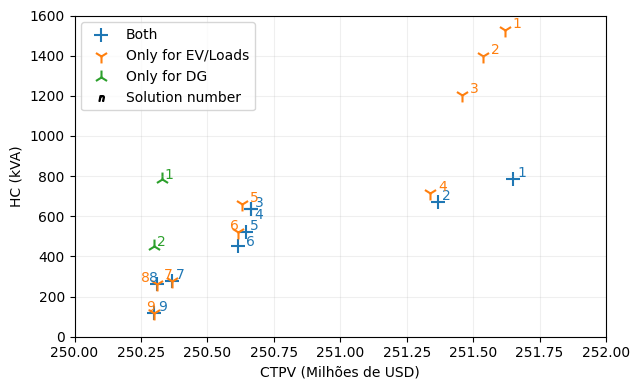

In [5]:
for i in range(0, len(df_both)):
    x = df_both[ctpv_label].iloc[i]
    y = df_both[hc_label].iloc[i]
    n = i+1
    dx = 0.015
    dy = 10
    if n == 4:
        dy = -50
    if n == 6:
        dy = 0
        dx = 0.030
    if n == 8:
        dx = -0.030
    ax.annotate(n, xy=(x, y), xytext=(x + dx, y + dy), color="#1f77b4")
for i in range(0, len(df_ev)):
    x = df_ev[ctpv_label].iloc[i]
    y = df_ev[hc_label].iloc[i]
    n = i+1
    dx = 0.030
    dy = 10
    if n == 6:
        dx = -0.030
    if n >= 7:
        dx = -0.030
    if n == 8:
        dx = -0.060
    ax.annotate(n, xy=(x, y), xytext=(x + dx, y + dy), color="#ff7f0e")
for i in range(0, len(df_gen)):
    x = df_gen[ctpv_label].iloc[i]
    y = df_gen[hc_label].iloc[i]
    n = i+1
    dx = 0.01
    dy = 0.01
    ax.annotate(n, xy=(x, y), xytext=(x + dx, y + dy), color="#2ca02c")
ax.legend()
fig

In [6]:
pos24 = {}
pos24[21] = (3, 6)
pos24[2]  = (4, 5)
pos24[12]  = (5, 5)

pos24[1]  = (2, 5)
pos24[14]  = (1, 5)
pos24[18]  = (1, 4)
pos24[24]  = (0, 3)
pos24[5]  = (1, 3)
pos24[20]  = (0, 2)

pos24[6]  = (2, 2)
pos24[13]  = (1, 1)
pos24[22]  = (3, 0)
pos24[17]  = (3, 1)
pos24[15]  = (3, 2)
pos24[8]  = (4, 1)
pos24[19]  = (4, 2)
pos24[4]  = (3, 3)
pos24[7]  = (5, 2)
pos24[11]  = (6, 1)
pos24[23]  = (6, 3)
pos24[10]  = (5, 3)
pos24[16]  = (4, 3)
pos24[3]  = (5, 4)
pos24[9]  = (3, 4)

pos24_sh = {n: (pos24[n][0], pos24[n][1] - 0.17) for n in range(1, 25)}


### Generation 

/home/felipe/projetos/HCPlanning.jl/results/24bus/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1191: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  t = ax.text(
/home/felipe/projetos/HCPlanning.jl/results/24bus/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1023: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  t = ax.text(


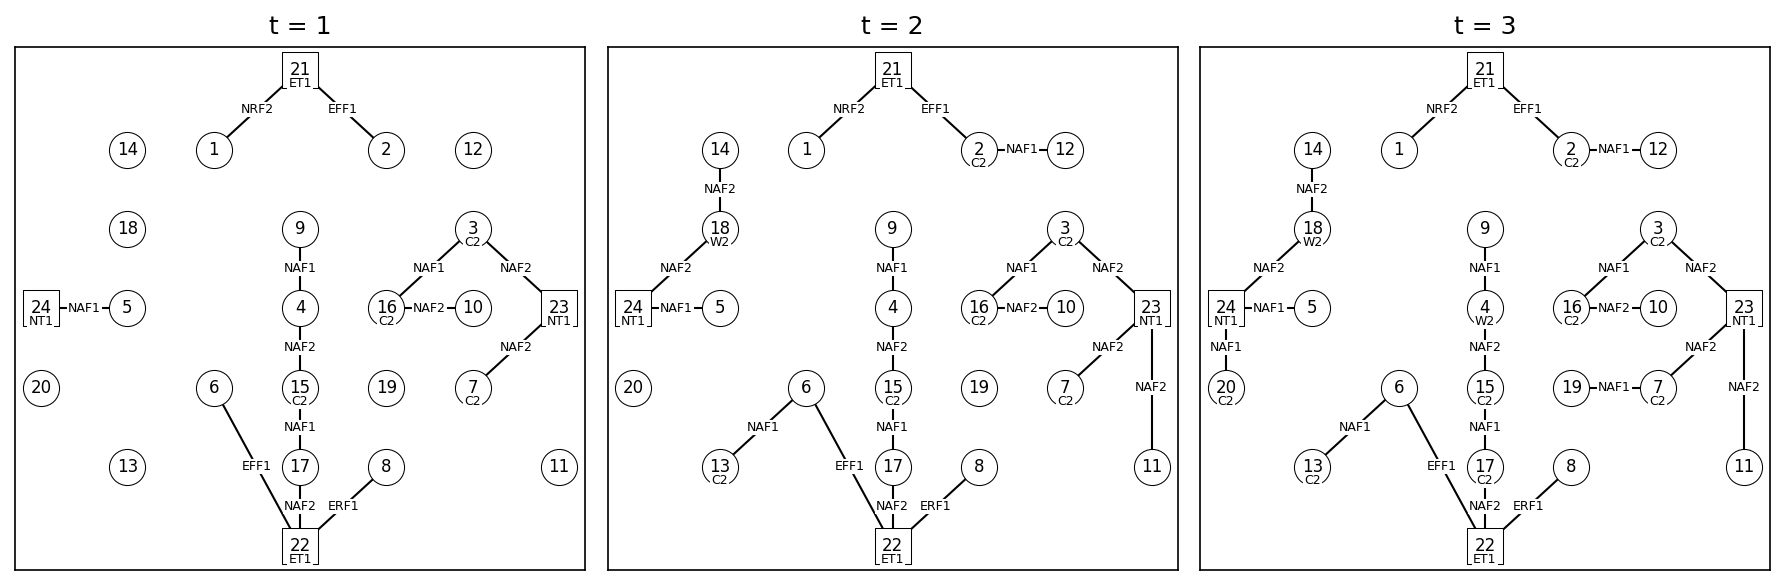

In [7]:
sys = parser_system("../../solutions/24_bus_gen1.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")


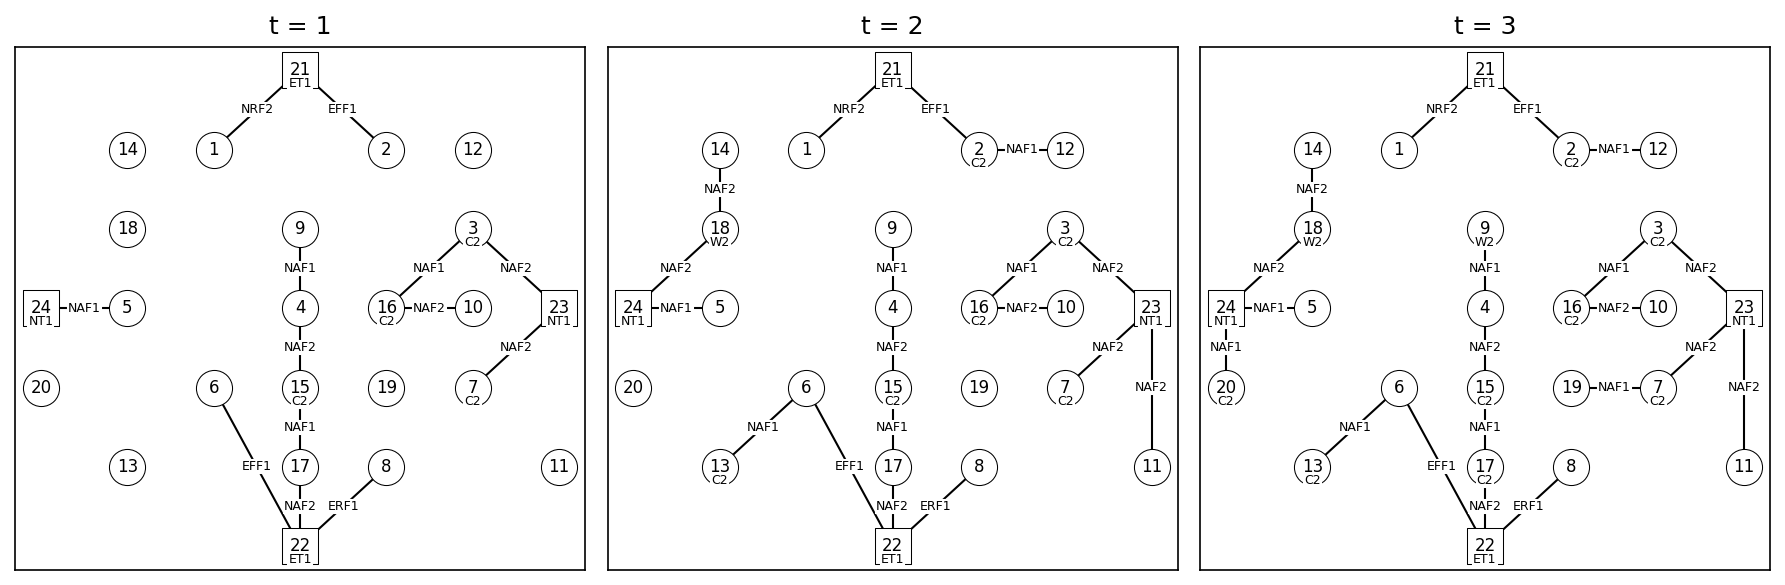

In [8]:
sys = parser_system("../../solutions/24_bus_gen2.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)
ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');

### Both

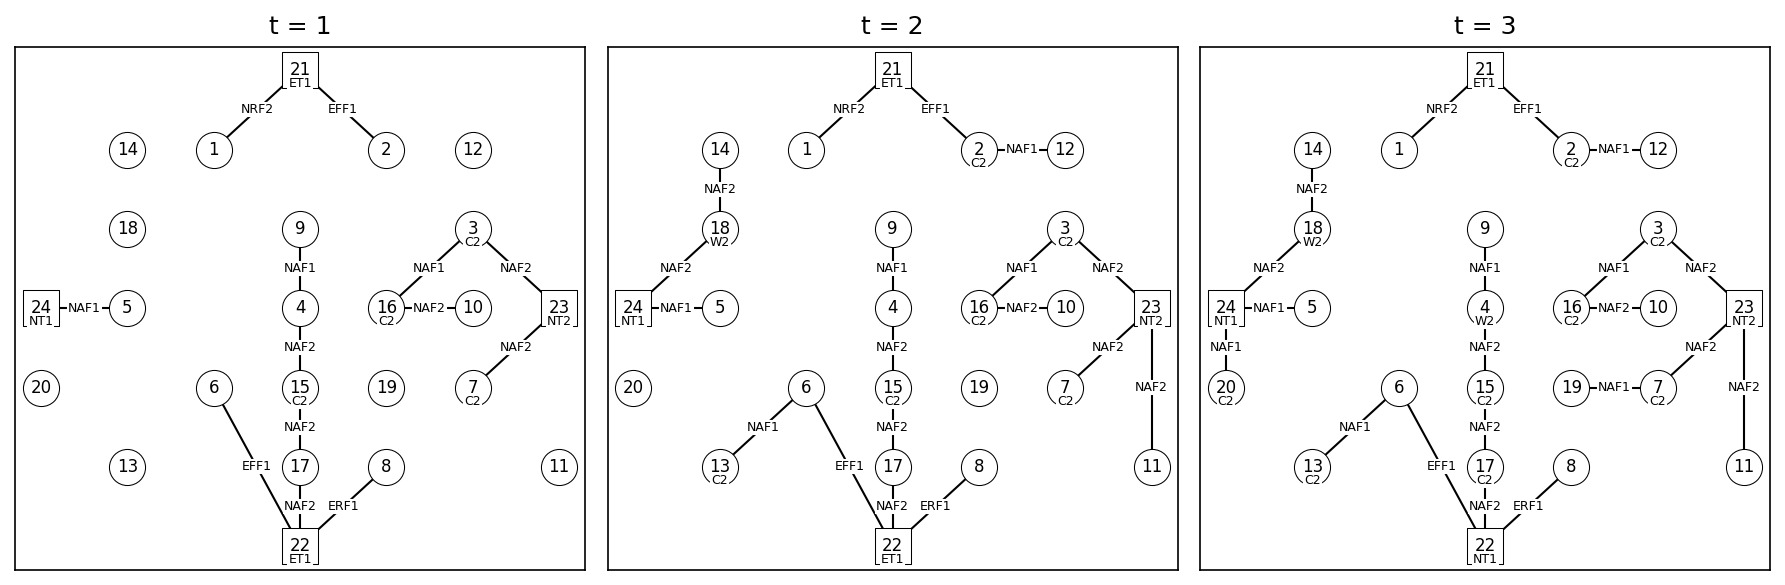

In [9]:
sys = parser_system("../../solutions/24_bus_both1.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")

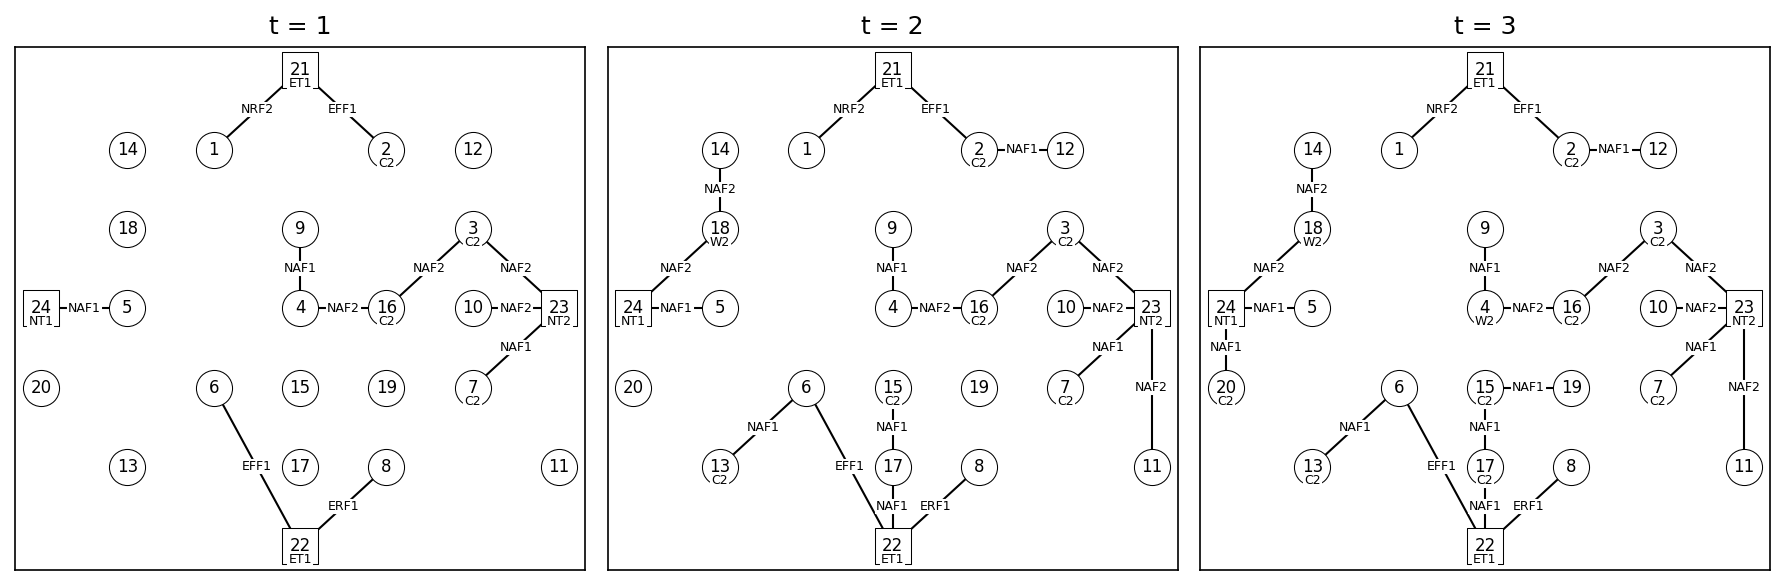

In [10]:
sys = parser_system("../../solutions/24_bus_both4.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")

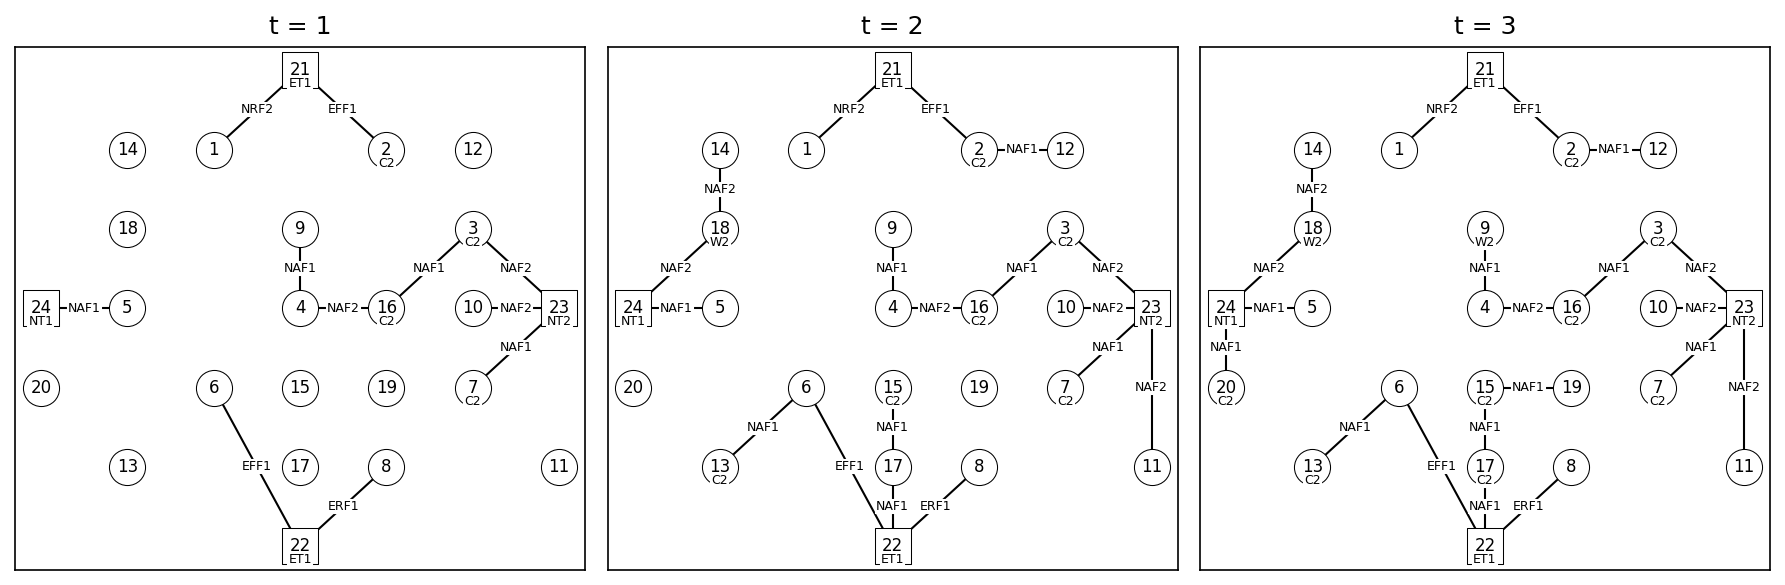

In [11]:
sys = parser_system("../../solutions/24_bus_both6.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")

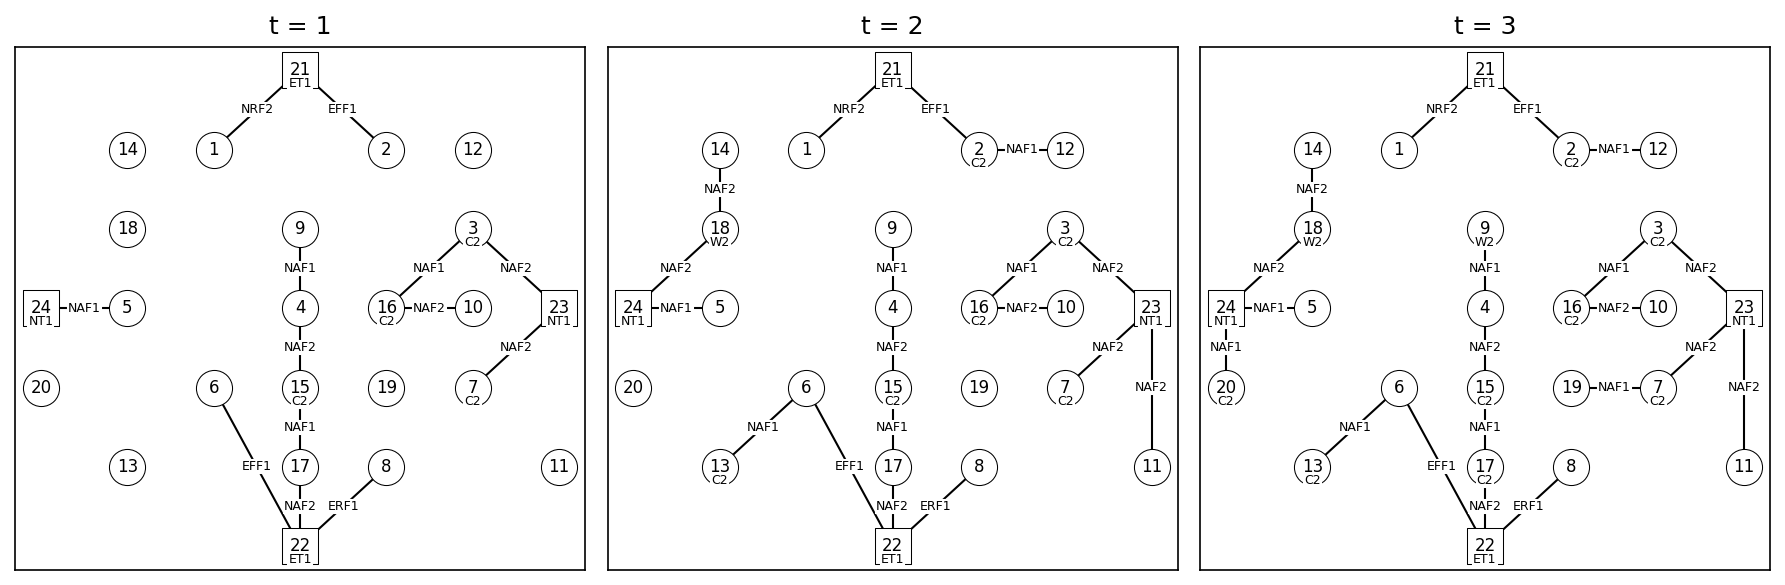

In [12]:
sys = parser_system("../../solutions/24_bus_both9.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")

### EV

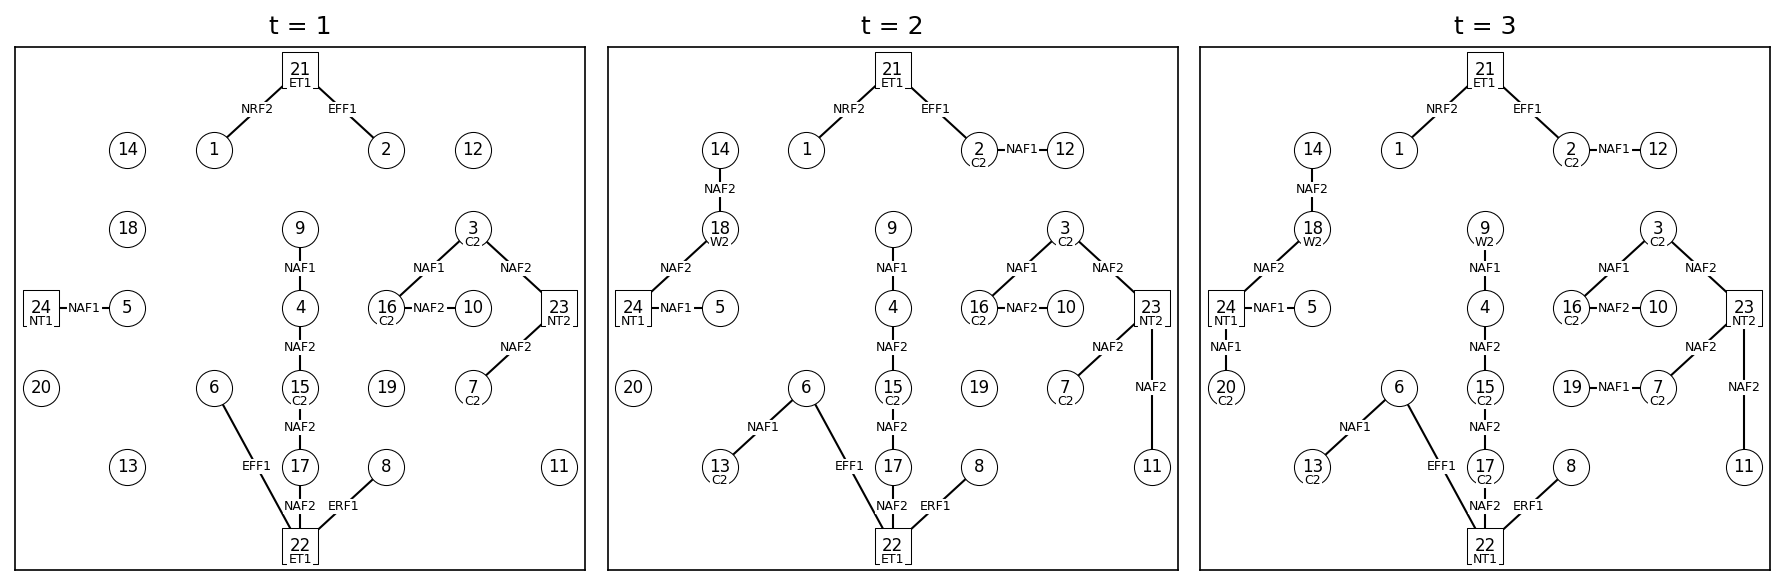

In [13]:
sys = parser_system("../../solutions/24_bus_ev1.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")

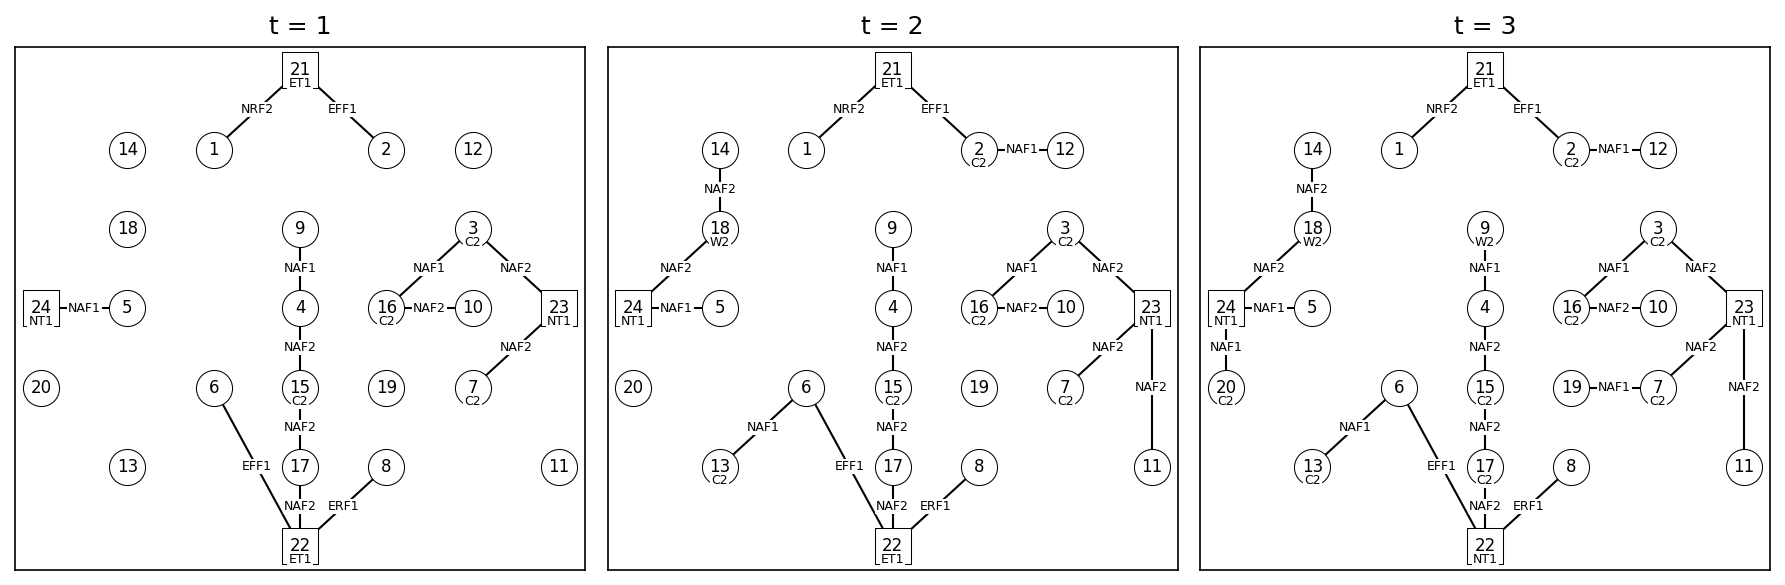

In [14]:
sys = parser_system("../../solutions/24_bus_ev4.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")

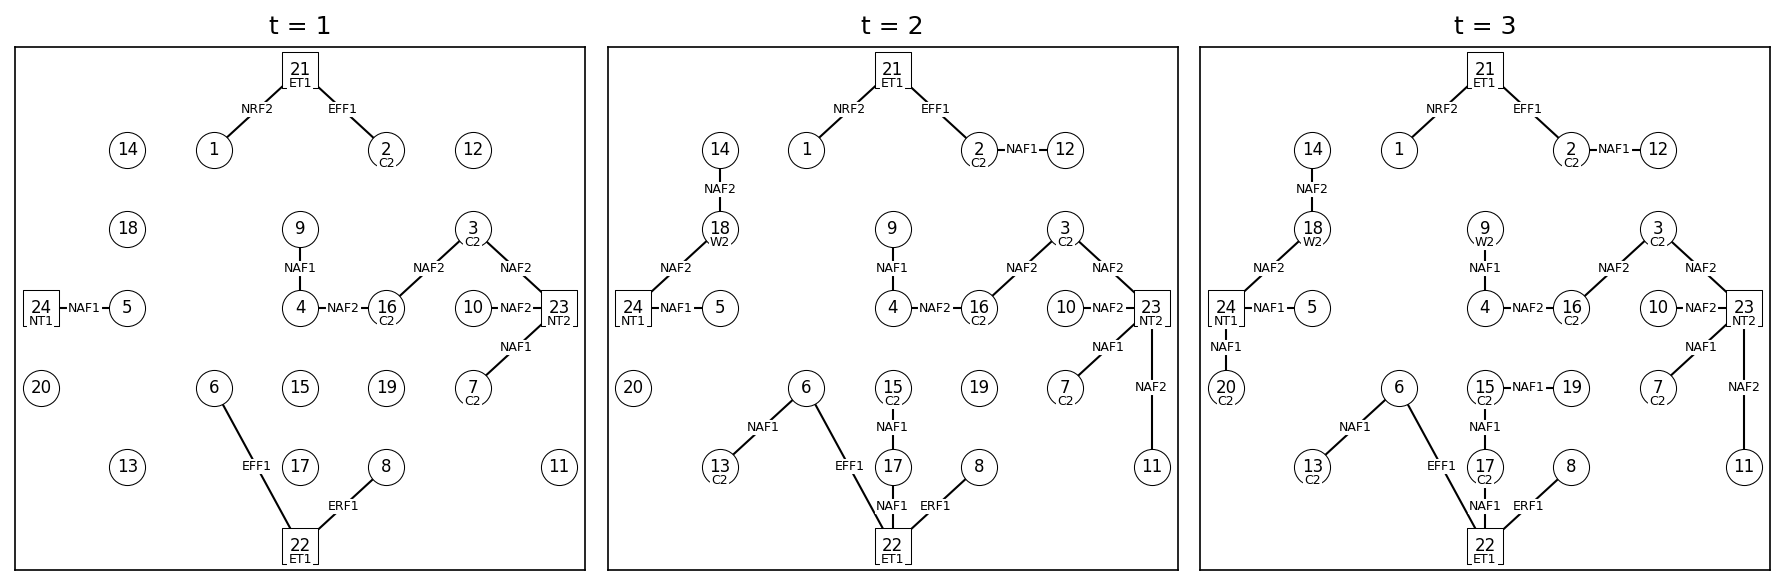

In [15]:
sys = parser_system("../../solutions/24_bus_ev5.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")

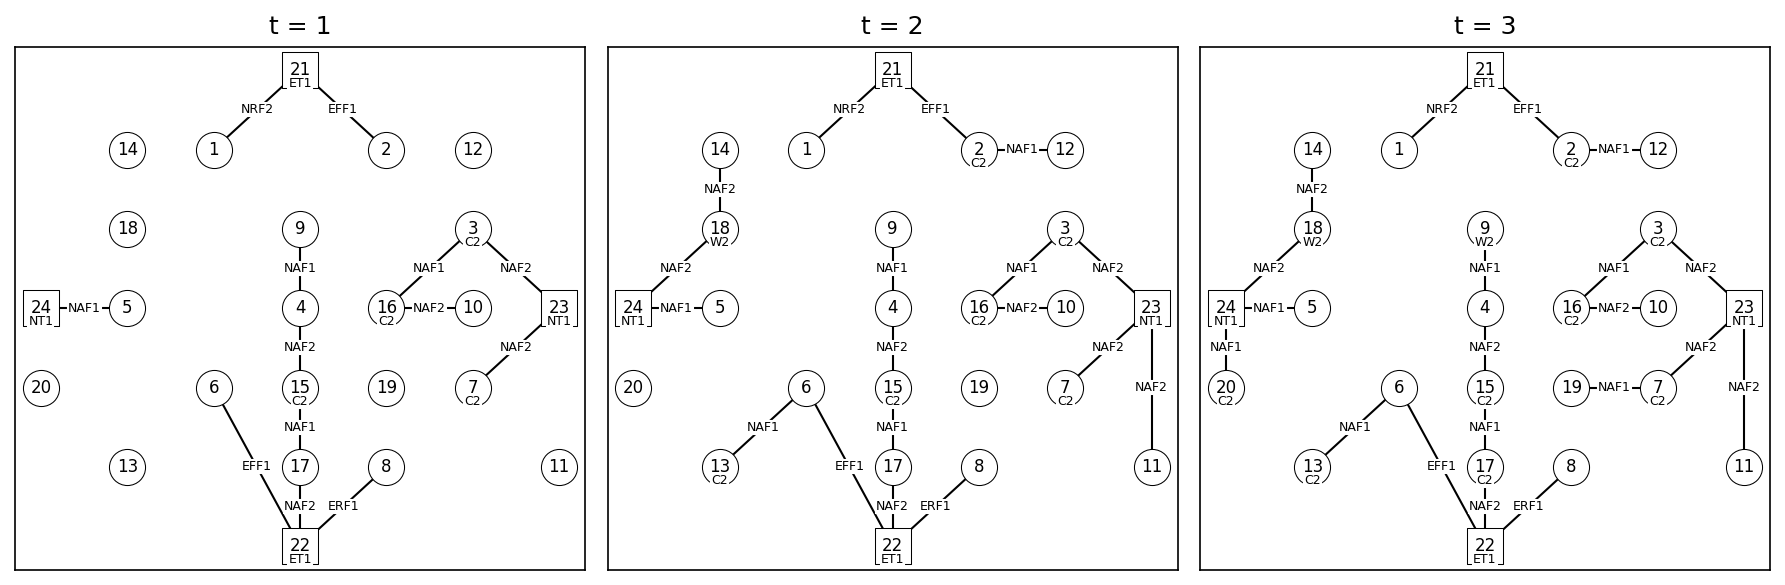

In [16]:
sys = parser_system("../../solutions/24_bus_ev9.jump_sol", 24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(150)
fig.set_size_inches(12, 4)
fig.set_tight_layout(True)
draw(sys, 1, pos24, pos24_sh, ax1)
draw(sys, 2, pos24, pos24_sh, ax2)
draw(sys, 3, pos24, pos24_sh, ax3)

ax1.set_title('t = 1')
#ax1.axis("off")

ax2.set_title('t = 2')
#ax2.axis("off")

ax3.set_title('t = 3');
#ax3.axis("off")

## 54 bus

In [17]:
df_both = parser_pareto("../../info_mult_54_both.log")
df_ev = parser_pareto("../../info_mult_54_ev.log")
df_gen = parser_pareto("../../info_mult_54_gen.log")

### CTPV

#### Raw

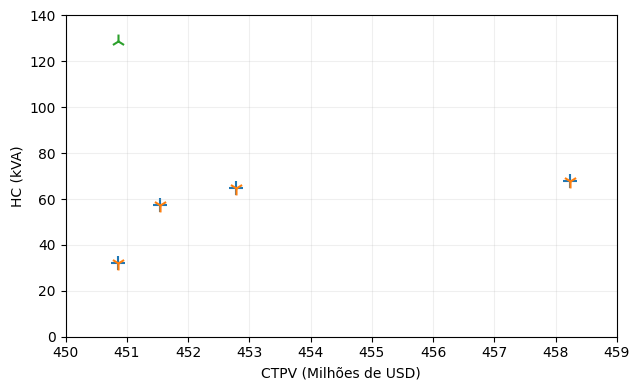

In [18]:
fig, ax = plt.subplots(figsize=(6.5, 4), layout="tight", dpi=100)
ax.set_xlabel(ctpv_label)
ax.set_ylabel(hc_label)
ax.set_xlim((450, 459))
ax.set_ylim((0, 140))
ax.grid(alpha=0.2)
ax.scatter(df_both[ctpv_label], df_both[hc_label], label="Both", marker="+", s=100)
ax.scatter(
    df_ev[ctpv_label], df_ev[hc_label], label="Only for EV/Loads", marker="1", s=100
)
ax.scatter(df_gen[ctpv_label], df_gen[hc_label], label="Only for DG", marker="2", s=100)
ax.scatter([-999], [-999], label="Solution number", marker="$n$", color="k", s=16) # for legend

#### Annotation

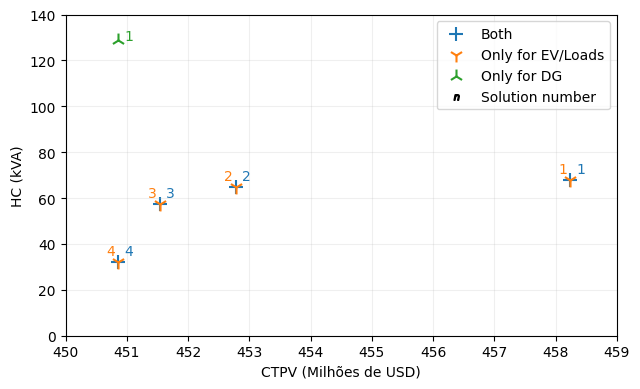

In [19]:
for i in range(0, len(df_both)):
    x = df_both[ctpv_label].iloc[i]
    y = df_both[hc_label].iloc[i]
    n = i+1
    dx = 0.1
    dy = 3
    ax.annotate(n, xy=(x, y), xytext=(x + dx, y + dy), color="#1f77b4")
for i in range(0, len(df_ev)):
    x = df_ev[ctpv_label].iloc[i]
    y = df_ev[hc_label].iloc[i]
    n = i+1
    dx = -0.2
    dy = 3
    ax.annotate(n, xy=(x, y), xytext=(x + dx, y + dy), color="#ff7f0e")
for i in range(0, len(df_gen)):
    x = df_gen[ctpv_label].iloc[i]
    y = df_gen[hc_label].iloc[i]
    n = i+1
    dx = 0.1
    dy = 0.01
    ax.annotate(n, xy=(x, y), xytext=(x + dx, y + dy), color="#2ca02c")
ax.legend()
fig

In [20]:
# import cv2
# import pytesseract
# import numpy as np
# import time
# PATH_TO_54BUS_IMG = "/home/felipe/Documentos/54bus.png"

# img = cv2.imread(PATH_TO_54BUS_IMG)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret,thresh = cv2.threshold(gray, 250, 255, 1)

# contours,h = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

# img2 = np.ones(thresh.shape)*255
# count = 0
# loc = {}

# for cnt in contours:
#     approx = cv2.approxPolyDP(cnt, 0.1*cv2.arcLength(cnt, True), True)
#     if len(approx) == 4:
#         (x,y),radius = cv2.minEnclosingCircle(cnt)
#         center_int = (int(x),int(y))
#         radius_int = int(radius)
#         l = radius*np.sqrt(2.0)/2.0

#         if (l*2.0) > (150) or (l*2 < 80):
#             continue
#         count += 1
        
#         p0 = (int(x - l), int(y - l))
#         p1 = (int(x + l), int(y + l))
#         data = thresh[p0[1]:p1[1], p0[0]:p1[0]]        
#         plt.imshow(data, cmap="gray", vmin=0, vmax=255)
#         plt.show()
#         n = int(input("Number: "))
#         loc[n] = center_int
#         # print(f"{n} => {center_int}")

import json

pos54 = {}
pos54_sh ={}
with open("54bus.json") as fp:
    raw = json.load(fp)
    pos54 = {int(key): raw[key] for key in raw.keys()}
    pos54_sh = {int(key): (raw[key][0], raw[key][1] - 60) for key in raw.keys()}

for n in range(1, 55):
    if n not in pos54.keys():
        print(f"Node {n} not found!")




### Generation

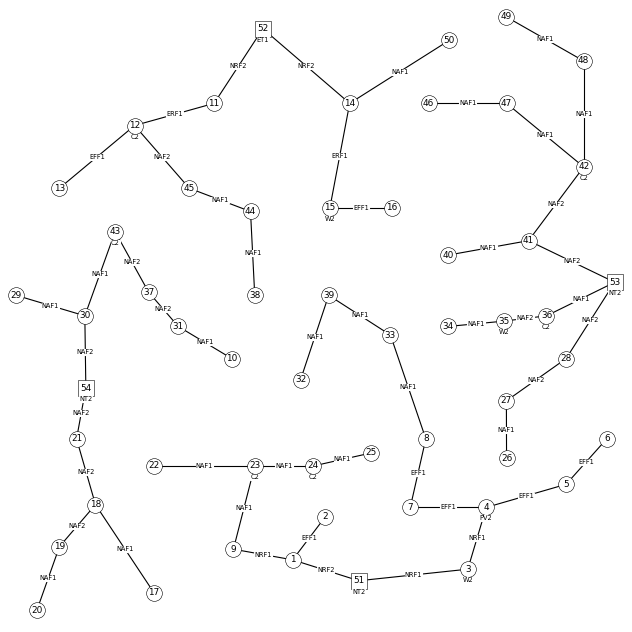

In [21]:
sys = parser_system("../../solutions/54_bus_gen1.jump_sol", 54)

fig, ax = plt.subplots(1, 1)
fig.set_dpi(80)
fig.set_size_inches(8, 8)
fig.set_tight_layout(True)
draw(sys, 3, pos54, pos54_sh, ax, node_size=200)
ax.set_ylim((0, 3360))
ax.set_xlim((30, 3670))
plt.axis('off')
fig.savefig("54_bus_gen.svg")
fig.savefig("54_bus_gen.pdf")

### Both

[<Axes: > <Axes: > <Axes: > <Axes: >]


/home/felipe/projetos/HCPlanning.jl/results/24bus/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1191: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  t = ax.text(
/home/felipe/projetos/HCPlanning.jl/results/24bus/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1023: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  t = ax.text(


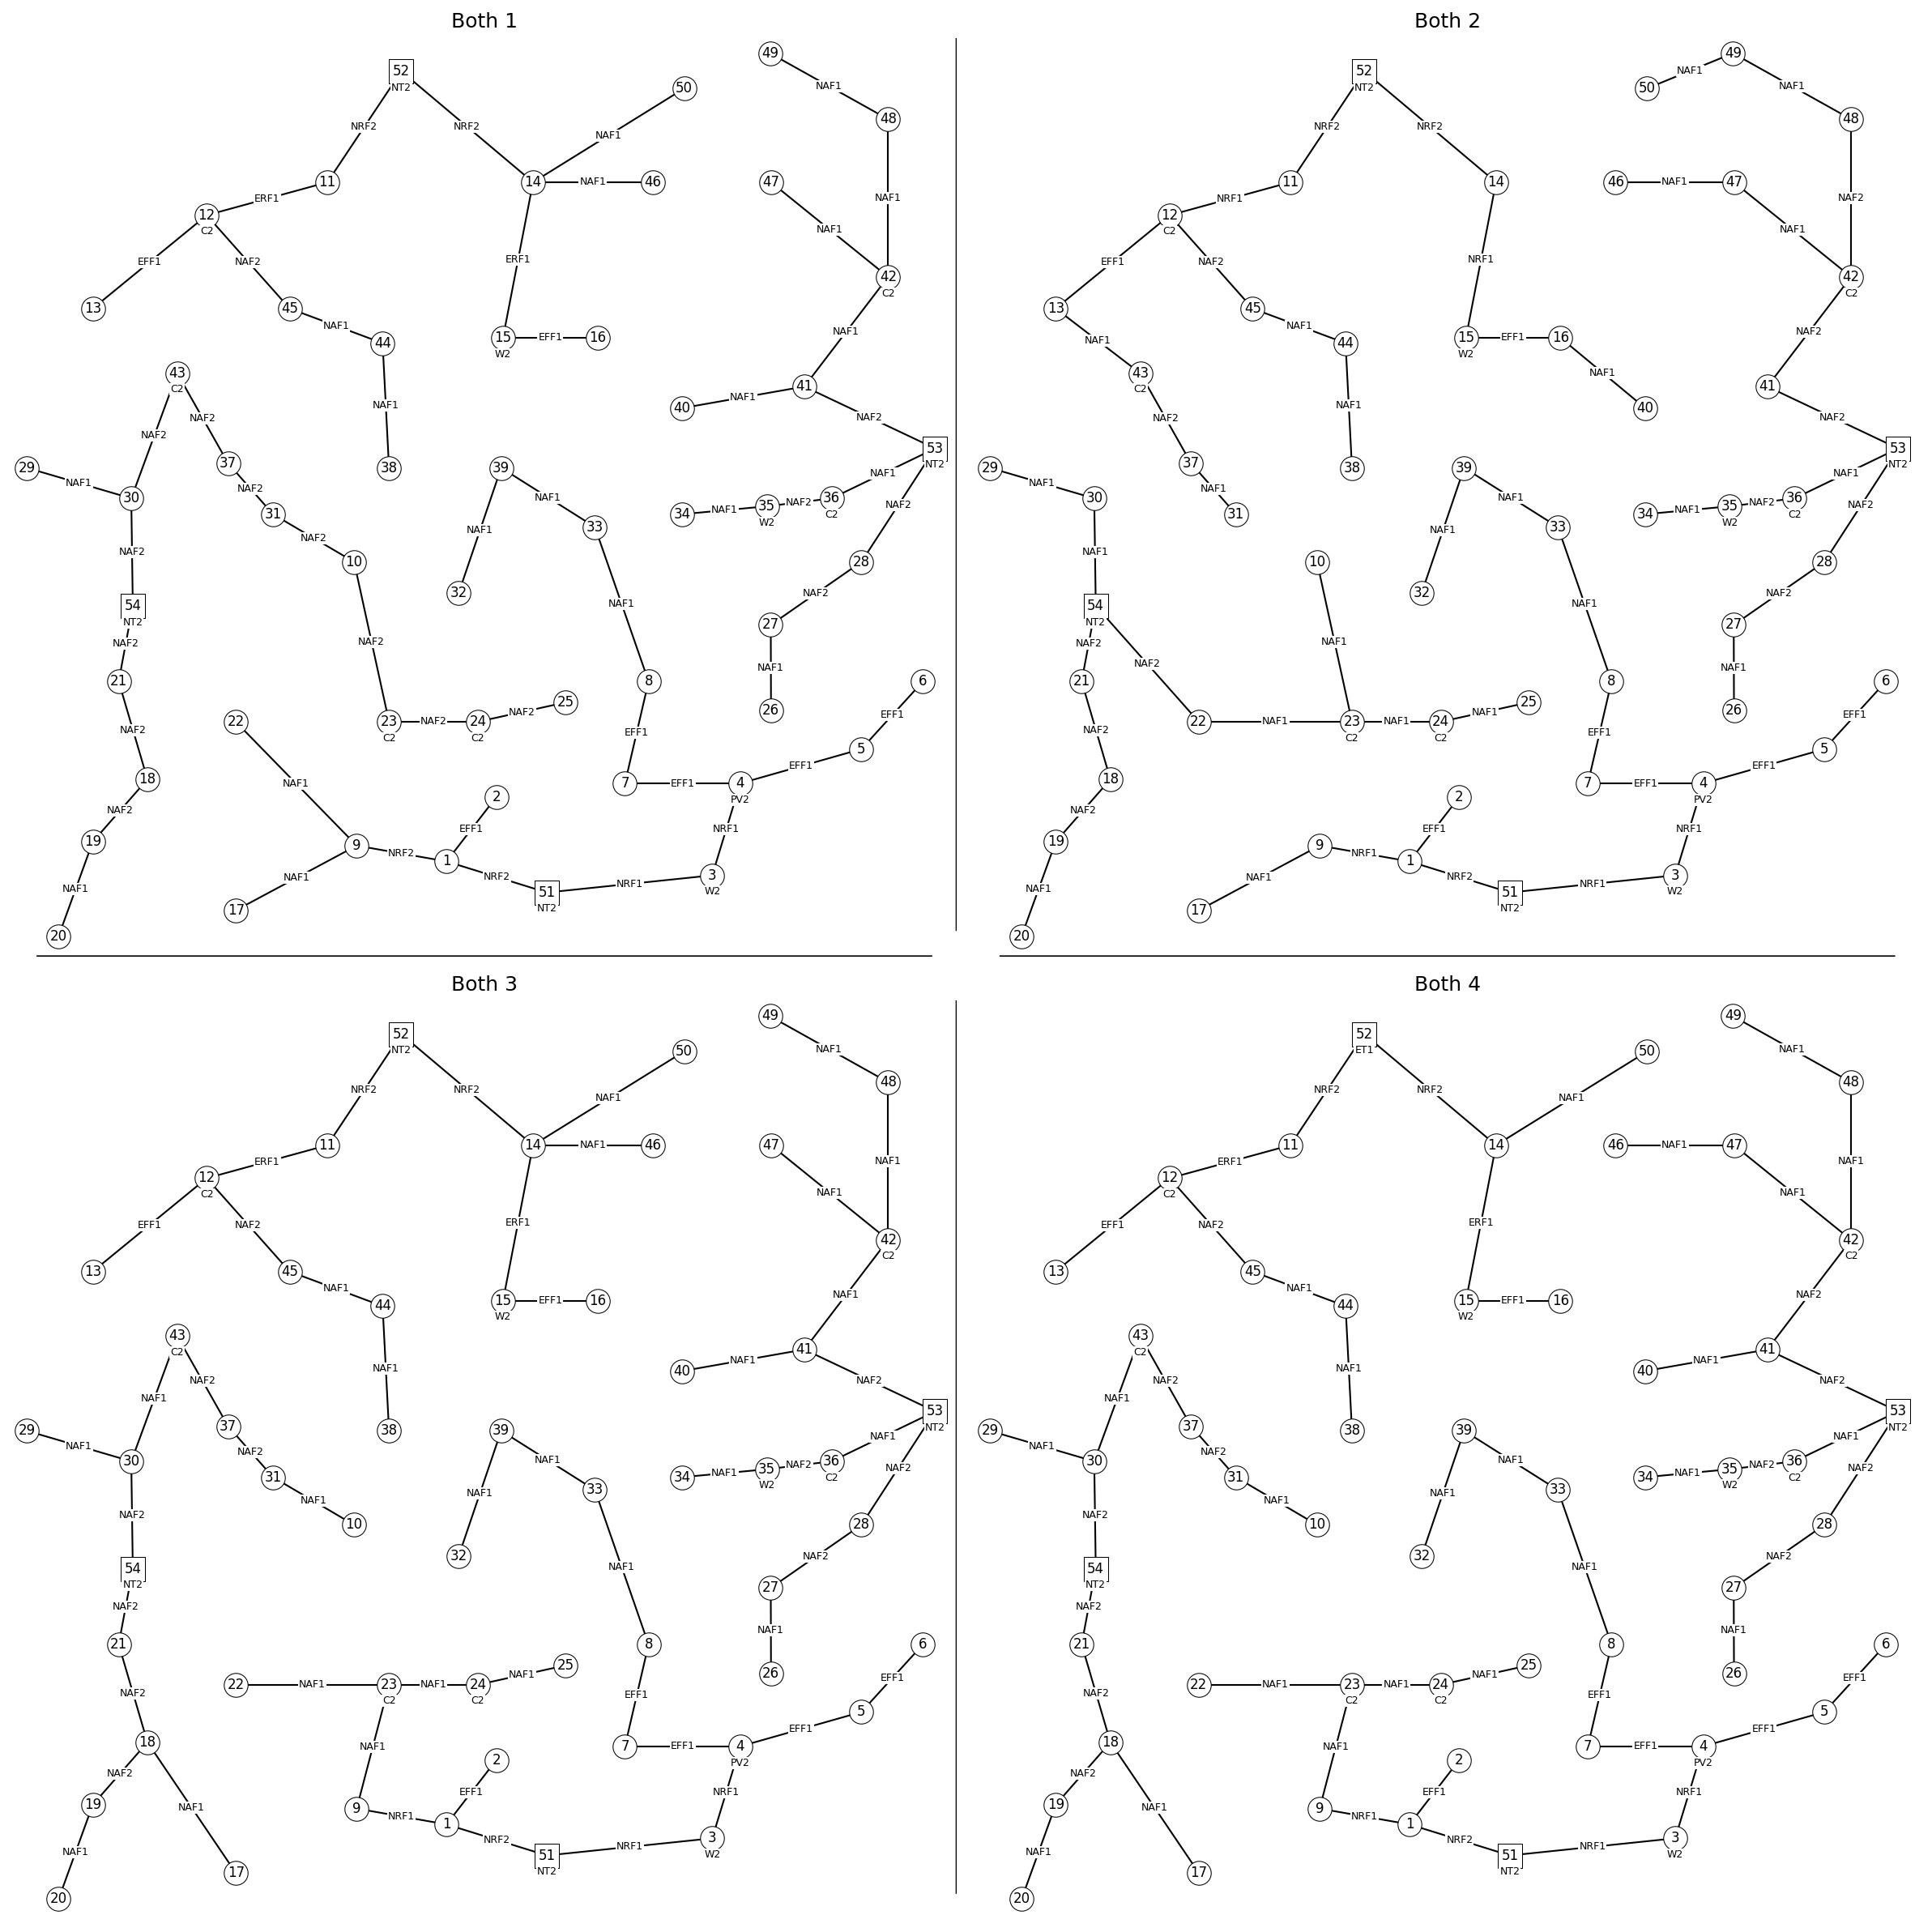

In [22]:
import matplotlib
import numpy as np

fig, axs = plt.subplots(2, 2)
fig.set_dpi(150)
fig.set_size_inches(8*2, 8*2)
fig.set_tight_layout(True)
axs = axs.reshape(-1,4)[0,:]
print(axs)

for i in range(0, 4):
    indx = i + 1
    sys = parser_system(f"../../solutions/54_bus_both{indx}.jump_sol", 54)  
    draw(sys, 3, pos54, pos54_sh, axs[i], node_size=200);
    axs[i].set_ylim((0, 3370))
    axs[i].set_xlim((20, 3700))
    axs[i].set_title(f"Both {indx}")
    axs[i].axis('off')
    
    x_data = np.array(range(120, 3600))
    y_data = np.ones(x_data.shape)
    h_line = matplotlib.lines.Line2D(x_data, y_data, color="k")
    if i < 2:
        axs[i].add_line(h_line)
    
    y_data = np.array(range(100, 3370))
    x_data = np.ones(y_data.shape)*3700
    v_line = matplotlib.lines.Line2D(x_data, y_data, color="k")
    if i == 0 or i == 2:
        axs[i].add_line(v_line)



fig.savefig("54_bus_both.svg")
fig.savefig("54_bus_both.pdf")

## 138 bus

### CTPV

In [23]:
df_both = parser_pareto("../../info_mult_138_both.log")
df_ev = parser_pareto("../../info_mult_138_ev.log")
df_gen = parser_pareto("../../info_mult_138_gen.log")

In [24]:
df_both

,HC (kVA),CTPV (Milhões de USD)
0,68.904958,122.350811
1,68.806355,122.349868
2,68.709667,122.347499
3,68.698000,118.998395
4,67.338971,118.844396
5,67.244848,118.843918
6,65.920417,118.804314
7,64.379000,118.444887
8,58.126176,118.413039
9,54.787317,118.390984


#### Raw

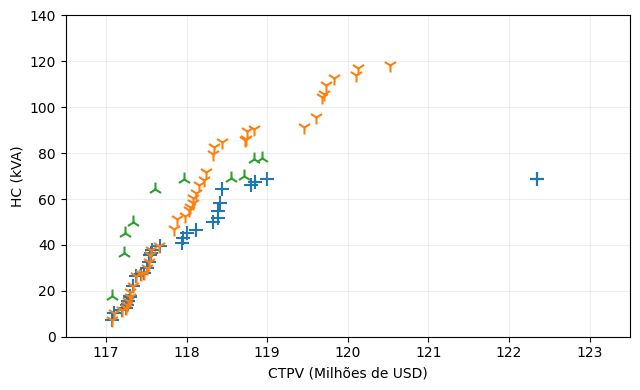

In [25]:
fig, ax = plt.subplots(figsize=(6.5, 4), layout="tight", dpi=100)
ax.set_xlabel(ctpv_label)
ax.set_ylabel(hc_label)
#ax.set_xlim((116.5, 123.5))
ax.set_xlim((116.5, 123.5))
ax.set_ylim((0, 140))
ax.grid(alpha=0.2)
ax.scatter(df_both[ctpv_label], df_both[hc_label], label="Both", marker="+", s=100)
ax.scatter(
    df_ev[ctpv_label], df_ev[hc_label], label="Only for EV/Loads", marker="1", s=100
)
ax.scatter(df_gen[ctpv_label], df_gen[hc_label], label="Only for DG", marker="2", s=100)
ax.scatter([-999], [-999], label="Solution number", marker="$n$", color="k", s=16) # for legend

In [26]:
for i in range(1, 34):
    ant = i
    nxt = i+1
    inv_ant = parser_investiment(f"../../solutions/138_bus_both{ant}.jump_sol", [136, 137, 138], [10])
    inv_next = parser_investiment(f"../../solutions/138_bus_both{nxt}.jump_sol", [136, 137, 138], [10])

    dg1 = inv_ant.dgs.difference(inv_next.dgs)
    dg2 = inv_next.dgs.difference(inv_ant.dgs)

    sub1 = inv_ant.substations.difference(inv_next.substations)
    sub2 = inv_next.substations.difference(inv_ant.substations)

    tr1 = inv_ant.transformers.difference(inv_next.transformers)
    tr2 = inv_next.transformers.difference(inv_ant.transformers)

    line1 = inv_ant.lines.difference(inv_next.lines)
    line2 = inv_next.lines.difference(inv_ant.lines)

    print(f"In {ant} but not in {nxt}:")
    if len(dg1):
        print("\tDG: ")
    for dg in dg1:
        print(f"\t\t{dg}")

    if len(sub1):
        print("\tSUBSTATION: ")
    for sub in sub1:
        print(f"\t\t{sub}")

    if len(tr1):
        print("\tTRANSFORMER: ")
    for tr in tr1:
        print(f"\t\t{tr}")

    if len(line1):
        print("\tLINE: ")
    for line in line1:
        print(f"\t\t{line}")


    print(f"In {nxt} but not in {ant}:")

    if len(dg2):
        print("\tDG: ")
    for dg in dg2:
        print(f"\t\t{dg}")

    if len(sub2):
        print("\tSUBSTATION: ")
    for sub in sub2:
        print(f"\t\t{sub}")

    if len(tr2):
        print("\tTRANSFORMER: ")
    for tr in tr2:
        print(f"\t\t{tr}")

    if len(line2):
        print("\tLINE: ")
    for line in line2:
        print(f"\t\t{line}")
    print("-"*100)
    



In 1 but not in 2:
	LINE: 
		Line(category='NRF', bus1=35, bus2=36, alternative=1, time=10)
		Line(category='NAF', bus1=53, bus2=54, alternative=1, time=10)
		Line(category='NAF', bus1=108, bus2=122, alternative=2, time=10)
In 2 but not in 1:
	LINE: 
		Line(category='NAF', bus1=53, bus2=54, alternative=2, time=10)
		Line(category='NAF', bus1=108, bus2=122, alternative=1, time=10)
		Line(category='NRF', bus1=35, bus2=136, alternative=1, time=10)
----------------------------------------------------------------------------------------------------
In 2 but not in 3:
	DG: 
		DG(category='C', bus=64, alternative=2, time=10)
		DG(category='C', bus=133, alternative=1, time=10)
	LINE: 
		Line(category='NAF', bus1=15, bus2=120, alternative=1, time=10)
		Line(category='NAF', bus1=61, bus2=62, alternative=1, time=10)
In 3 but not in 2:
	DG: 
		DG(category='C', bus=64, alternative=1, time=10)
		DG(category='C', bus=133, alternative=2, time=10)
	LINE: 
		Line(category='NAF', bus1=15, bus2=121, alter